## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [3]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [4]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

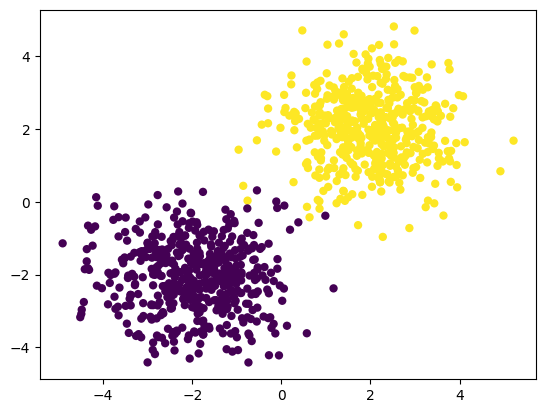

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [10]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

print(net)


Linear 2 -> 2
LogSoftMax



In [11]:
# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [12]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [13]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

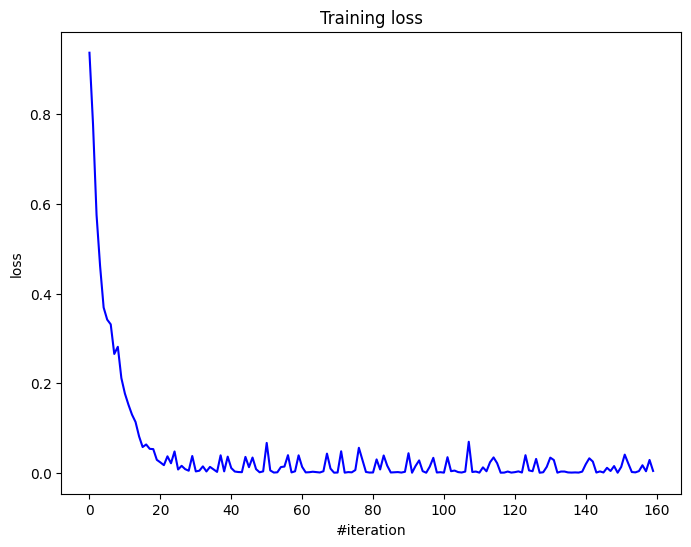

Current loss: 0.004583


In [14]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [15]:

import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img

    return images, labels


X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

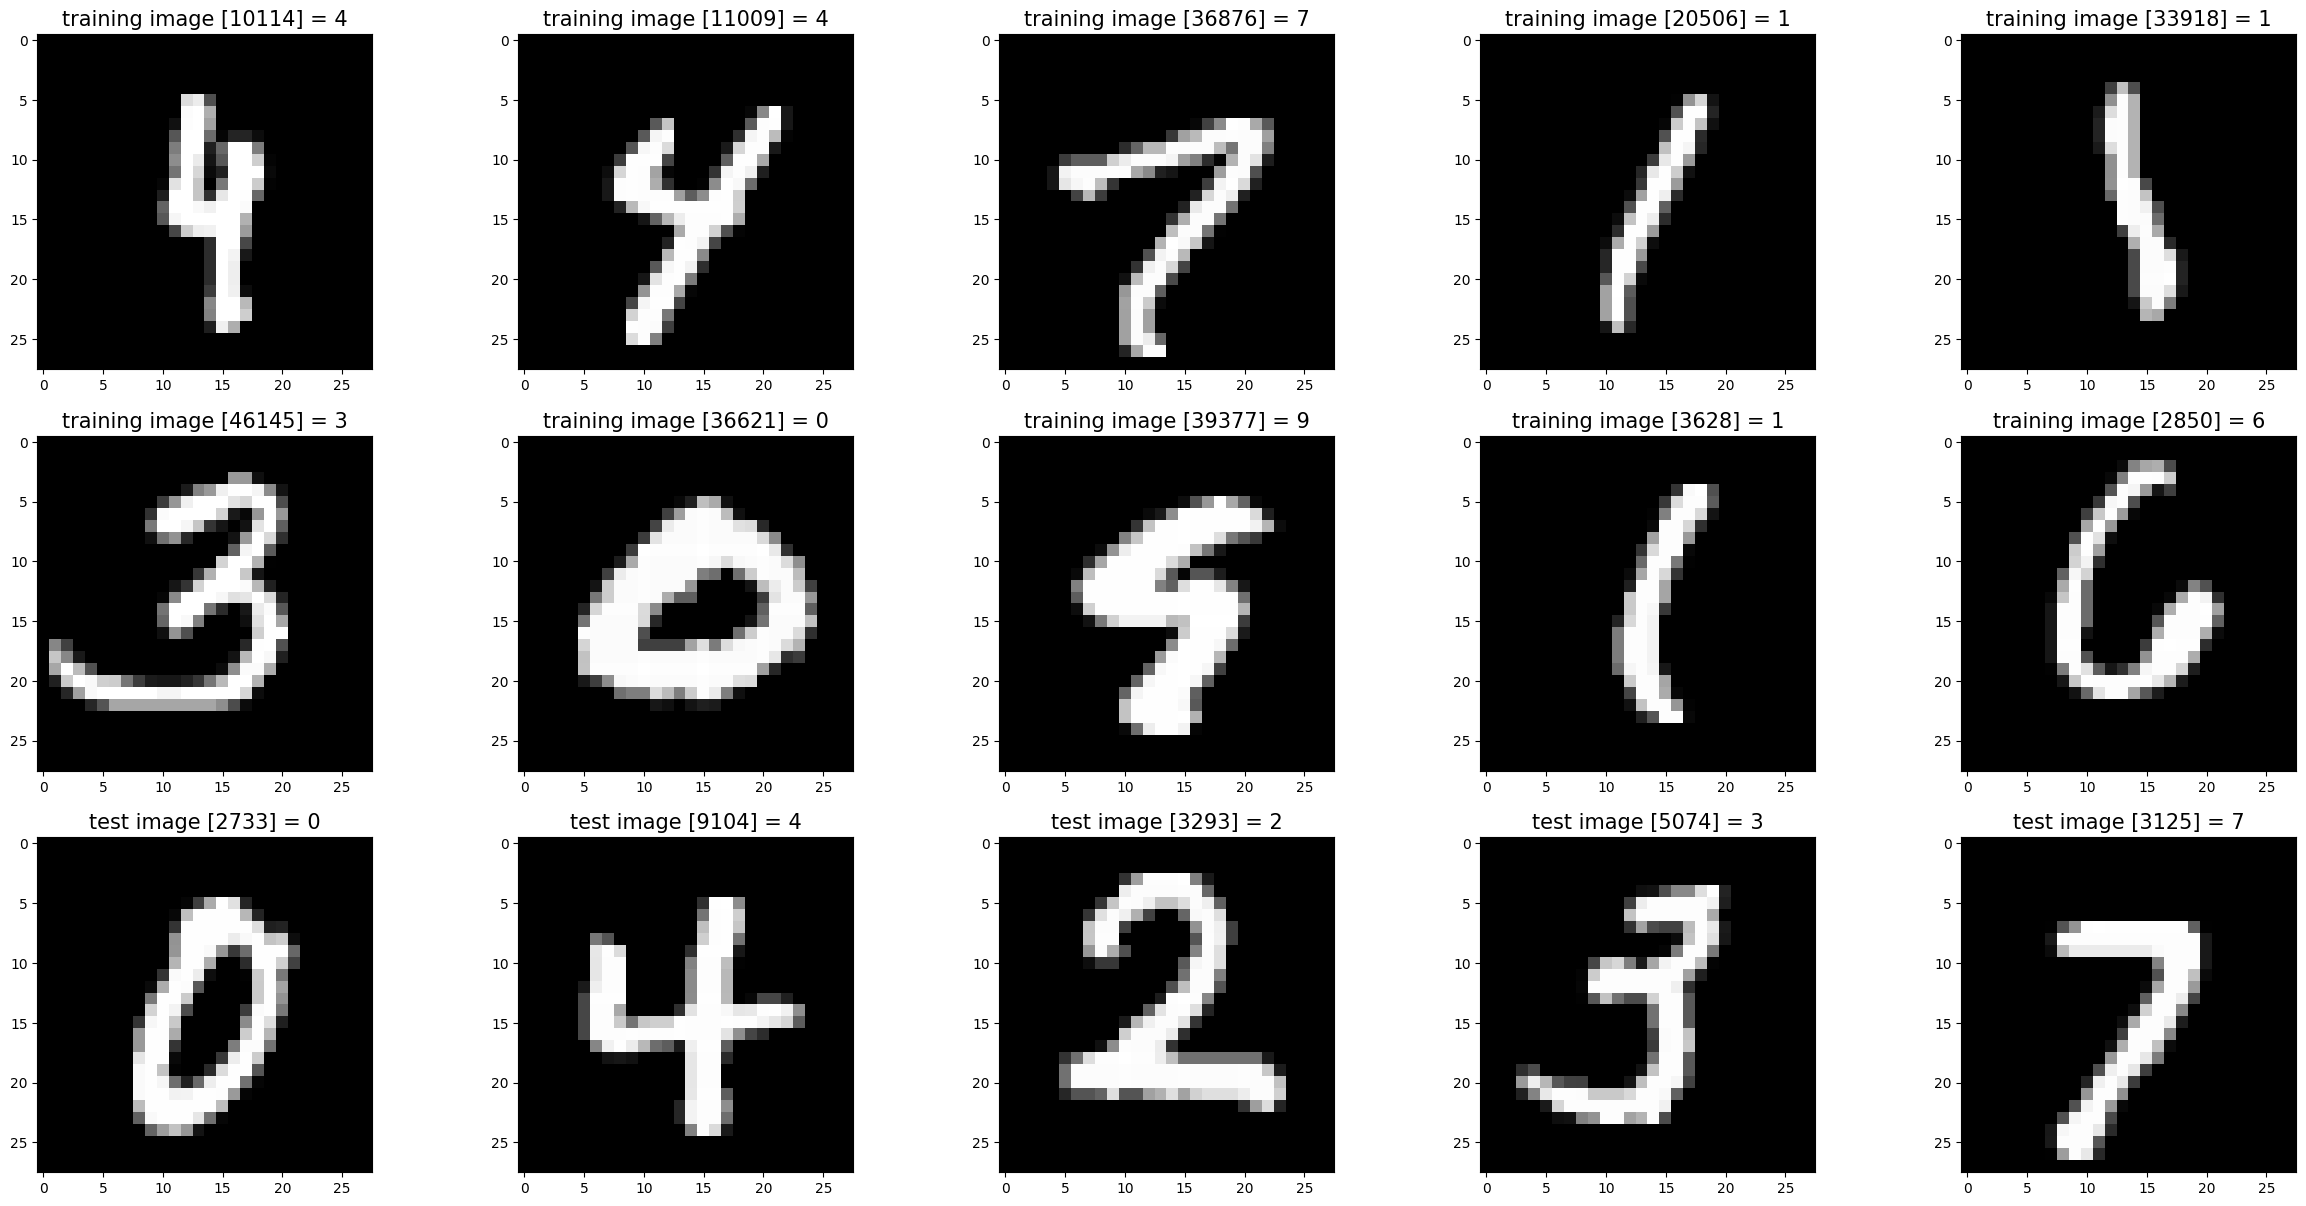

In [16]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

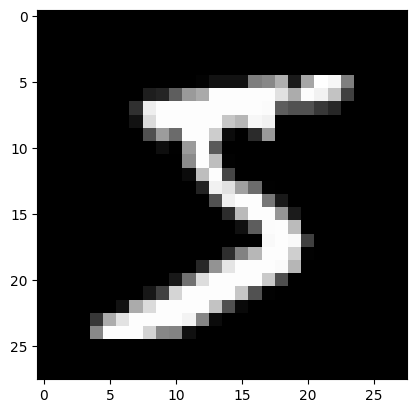

In [17]:
plt.imshow(X_train[0], cmap='gray')

In [18]:
from sklearn.preprocessing import OneHotEncoder
num_classes = 10

y_train = np.array(y_train)
y_test = np.array(y_test)

encoder = OneHotEncoder(categories='auto', sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))


print(y_train[:5])
print(y_train_one_hot[:5])

print(y_test[:5])
print(y_test_one_hot[:5])

[5 0 4 1 9]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[7 2 1 0 4]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [19]:
X_train = np.array(X_train).reshape(-1, 28 * 28)  # Преобразование в (n_samples, 784)
X_test = np.array(X_test).reshape(-1, 28 * 28)

X_train = X_train / 255.0
X_test = X_test / 255.0

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.


Функция: ReLU
Эпоха 1: текущая потеря- 0.5959
Эпоха 2: текущая потеря- 0.3511
Эпоха 3: текущая потеря- 0.3868
Эпоха 4: текущая потеря- 0.3882
Эпоха 5: текущая потеря- 0.3329
Эпоха 6: текущая потеря- 0.3209
Эпоха 7: текущая потеря- 0.3173
Эпоха 8: текущая потеря- 0.2632
Эпоха 9: текущая потеря- 0.2281
Эпоха 10: текущая потеря- 0.2077

Функция: ELU
Эпоха 1: текущая потеря- 0.5183
Эпоха 2: текущая потеря- 0.4197
Эпоха 3: текущая потеря- 0.3783
Эпоха 4: текущая потеря- 0.3690
Эпоха 5: текущая потеря- 0.2808
Эпоха 6: текущая потеря- 0.3001
Эпоха 7: текущая потеря- 0.3382
Эпоха 8: текущая потеря- 0.2982
Эпоха 9: текущая потеря- 0.2505
Эпоха 10: текущая потеря- 0.2360

Функция: LeakyReLU
Эпоха 1: текущая потеря- 0.6136
Эпоха 2: текущая потеря- 0.4018
Эпоха 3: текущая потеря- 0.3350
Эпоха 4: текущая потеря- 0.2959
Эпоха 5: текущая потеря- 0.2887
Эпоха 6: текущая потеря- 0.3479
Эпоха 7: текущая потеря- 0.2449
Эпоха 8: текущая потеря- 0.2394
Эпоха 9: текущая потеря- 0.2132
Эпоха 10: текущая пот

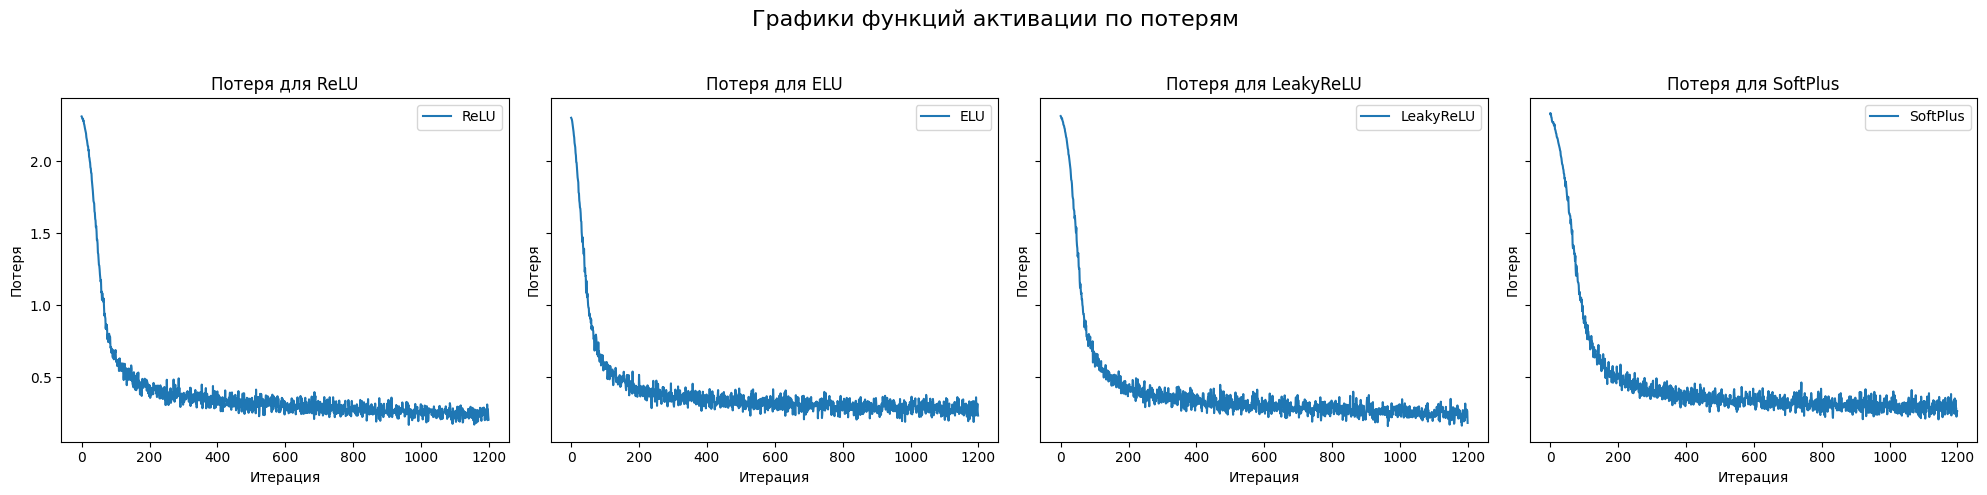

In [20]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}

n_epoch = 10
batch_size = 500

activations = [ReLU(), ELU(alpha=1.0), LeakyReLU(slope=0.1), SoftPlus()]

results = {}
loss_histories = {}
optimizer_state = {}
execution_times = {}

def create_model(activation):
    model = Sequential()
    model.add(Linear(28 * 28, 128))
    model.add(activation)
    model.add(Linear(128, 10))
    model.add(LogSoftMax())
    return model

def train_model(model, X_train, y_train_one_hot):
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            model.zeroGradParameters()
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)

            sgd_momentum(model.getParameters(),
                         model.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

def evaluate_model(model, X_test, y_test_one_hot):
    test_predictions = model.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)

    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy


for activation in activations:
    print(f"\nФункция: {activation}")
    net = create_model(activation)
    loss_history, execution_time = train_model(net, X_train, y_train_one_hot)
    accuracy = evaluate_model(net, X_test, y_test_one_hot)
    results[str(activation)] = {'accuracy': accuracy, 'execution_time': execution_time}
    loss_histories[str(activation)] = loss_history
    execution_times[str(activation)] = execution_time


print("\nСравнения моделей по точности и времени выполнения:")
for activation, metrics in results.items():
    print(f"\nФункция: {activation}")
    print(f"Точность: {metrics['accuracy']:.4f}")
    print(f"Время: {metrics['execution_time']:.2f} секунд")

def plot_loss_histories(loss_histories):
    num_activations = len(loss_histories)
    fig, axes = plt.subplots(1, num_activations, figsize=(20, 5), sharey=True)

    for i, (activation, history) in enumerate(loss_histories.items()):
        axes[i].plot(history, label=str(activation))
        axes[i].set_title(f"Потеря для {activation}")
        axes[i].set_xlabel("Итерация")
        axes[i].set_ylabel("Потеря")
        axes[i].legend()

    plt.suptitle("Графики функций активации по потерям", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_loss_histories(loss_histories)


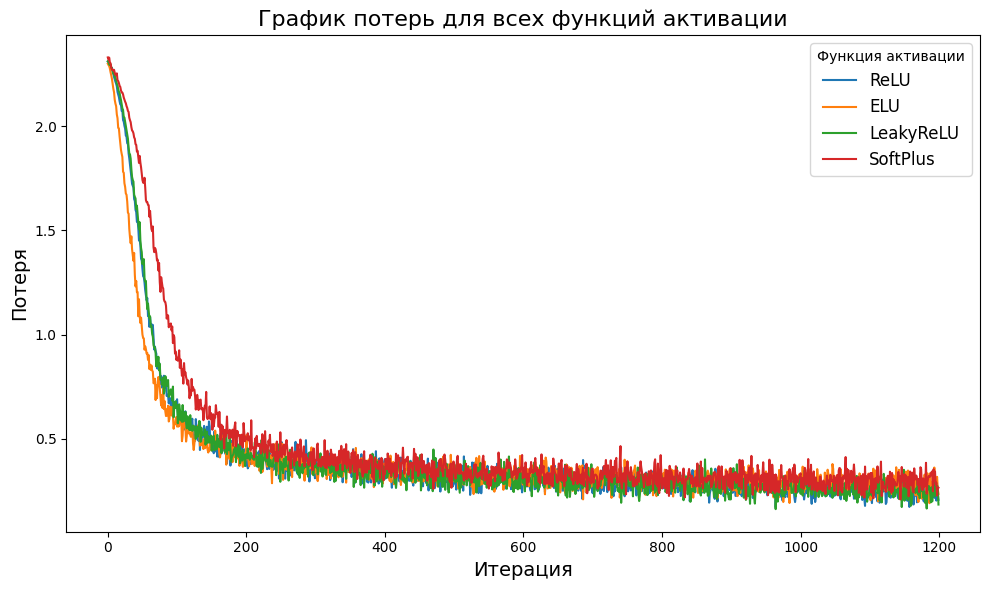

In [21]:
def plot_loss_histories(loss_histories):
    plt.figure(figsize=(10, 6))

    for activation, history in loss_histories.items():
        plt.plot(history, label=str(activation))

    plt.title("График потерь для всех функций активации", fontsize=16)
    plt.xlabel("Итерация", fontsize=14)
    plt.ylabel("Потеря", fontsize=14)
    plt.legend(title="Функция активации", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_loss_histories(loss_histories)

Выводы на основе полученных данных:

Точность:

- ReLU имеет наибольшую точность (0.9361).
- LeakyReLU немного отстает, с точностью 0.9315.
- ELU имеет точность 0.9246, что также достаточно высоко
- SoftPlus показывает наименьшую точность — 0.9198.

Время выполнения:
Все модели имеют похожее время выполнения, с минимальной разницей:
- ReLU: 325.60 секунд
- ELU: 321.52 секунд
- LeakyReLU: 320.57 секунд
- SoftPlus: 320.58 секунд

Таким образом, если ключевым фактором является точность, модель с функцией ReLU показывает лучший результат, хотя и с небольшим увеличением времени выполнения. Если же требуется оптимизация по времени, то разница в времени между моделями минимальна, и можно выбрать модель с LeakyReLU, которая имеет почти минимально время, и лишь немного отстает от ReLU.

Останавлюсь на LeakyReLU

In [22]:
X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train = np.array(X_train).reshape(-1, 28 * 28)
X_test = np.array(X_test).reshape(-1, 28 * 28)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [23]:
np.random.seed(42)
def train_model(net, model_name):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()
    optimizer_state = {}

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy


In [24]:
np.random.seed(42)
import time
optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}
n_epoch = 10
batch_size = 500
results = {}
loss_histories = {}
execution_times = {}

net_without_norm = Sequential()
net_without_norm.add(Linear(28 * 28, 128))
net_without_norm.add(LeakyReLU(slope=0.1))
net_without_norm.add(Linear(128, 10))
net_without_norm.add(LogSoftMax())

net_with_norm = Sequential()
net_with_norm.add(Linear(28 * 28, 128))
batch_norm_0 = BatchNormalization(128)
batch_norm_0.alpha = 0.9
net_with_norm.add(batch_norm_0)
net_with_norm.add(ChannelwiseScaling(128))
net_with_norm.add(LeakyReLU(slope=0.1))
net_with_norm.add(Linear(128, 10))
net_with_norm.add(LogSoftMax())

np.random.seed(42)
print("\nБез нормализации:")
loss_without_norm, time_without_norm = train_model(net_without_norm, "Без нормализации")
np.random.seed(42)
print("\nС нормализацией:")
loss_with_norm, time_with_norm = train_model(net_with_norm, "С нормализацией")

accuracy_without_norm = evaluate_model(net_without_norm, "Без нормализации")
accuracy_with_norm = evaluate_model(net_with_norm, "С нормализацией")

print("\nРезультаты сравнения моделей:")

print("\nБез нормализации")
print(f"Точность: {accuracy_without_norm:.4f}")
print(f"Время: {time_without_norm:.2f} секунд")

print("\nС нормализацией")
print(f"Точность: {accuracy_with_norm:.4f}")
print(f"Время: {time_with_norm:.2f} секунд")


Без нормализации:
Эпоха 1: текущая потеря- 0.5413
Эпоха 2: текущая потеря- 0.4076
Эпоха 3: текущая потеря- 0.3824
Эпоха 4: текущая потеря- 0.3207
Эпоха 5: текущая потеря- 0.3535
Эпоха 6: текущая потеря- 0.2909
Эпоха 7: текущая потеря- 0.2722
Эпоха 8: текущая потеря- 0.3243
Эпоха 9: текущая потеря- 0.2830
Эпоха 10: текущая потеря- 0.2574

С нормализацией:
Эпоха 1: текущая потеря- 1.5632
Эпоха 2: текущая потеря- 0.4952
Эпоха 3: текущая потеря- 0.3591
Эпоха 4: текущая потеря- 0.2833
Эпоха 5: текущая потеря- 0.2792
Эпоха 6: текущая потеря- 0.2368
Эпоха 7: текущая потеря- 0.1989
Эпоха 8: текущая потеря- 0.2380
Эпоха 9: текущая потеря- 0.2178
Эпоха 10: текущая потеря- 0.1850

Результаты сравнения моделей:

Без нормализации
Точность: 0.9308
Время: 312.25 секунд

С нормализацией
Точность: 0.9507
Время: 318.88 секунд


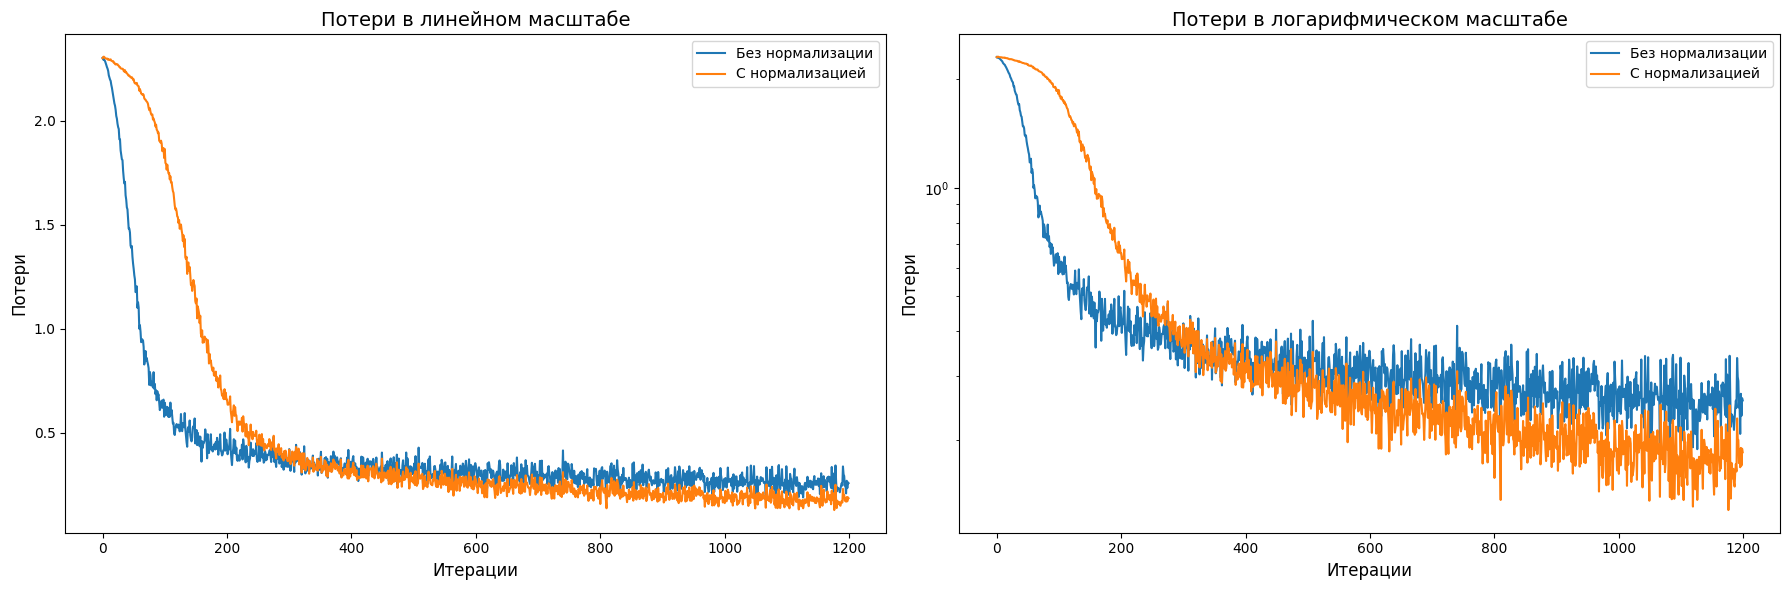

In [25]:
# Добавление потерь в историю
loss_histories["Без нормализации"] = loss_without_norm
loss_histories["С нормализацией"] = loss_with_norm

# Создание двух подграфиков (один для линейного масштаба, второй для логарифмического)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 строка, 2 столбца

# Построение графика с линейным масштабом
for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

# Подписываем оси для линейного графика
axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

# Построение графика с логарифмическим масштабом
for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

# Устанавливаем логарифмический масштаб для оси y
axes[1].set_yscale("log")

# Подписываем оси для логарифмического графика
axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

# Компоновка графиков для лучшего отображения
plt.tight_layout()

# Показ графиков
plt.show()

In [26]:
# Перейдем к сравнению momentum_sgd и Adam
# Загрузка данных
X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

# Предобработка данных
X_train = np.array(X_train).reshape(-1, 28 * 28)
X_test = np.array(X_test).reshape(-1, 28 * 28)

X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot кодирование меток
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_one_hot = one_hot_encode(y_train, 10)
y_test_one_hot = one_hot_encode(y_test, 10)

In [27]:
# Функция для обучения модели
def train_model(net, model_name, optimizer, optimizer_config):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()
    optimizer_state = {}

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

In [28]:
# Функция для оценки модели
def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy

In [29]:
# Гиперпараметры
np.random.seed(42)
optimizer_config_sgd = {'learning_rate': 1e-2, 'momentum': 0.9}

# Гиперпараметры для Adam
optimizer_config_adam = {
    'learning_rate': 1e-3,
    'beta1': 0.9,       # Параметр для первого момента
    'beta2': 0.999,     # Параметр для второго момента
    'epsilon': 1e-8     # Малое число для предотвращения деления на 0
}

n_epoch = 10
batch_size = 500

# Создание модели для сравнения
net_adam = Sequential()
net_adam.add(Linear(28 * 28, 128))
net_adam.add(LeakyReLU(slope=0.1))
net_adam.add(Linear(128, 10))
net_adam.add(LogSoftMax())

net_adam_norm = Sequential()
net_adam_norm.add(Linear(28 * 28, 128))
batch_norm_1 = BatchNormalization(128)
batch_norm_1.alpha = 0.9
net_adam_norm.add(batch_norm_1)
net_adam_norm.add(ChannelwiseScaling(128))
net_adam_norm.add(LeakyReLU(slope=0.1))
net_adam_norm.add(Linear(128, 10))
net_adam_norm.add(LogSoftMax())

# Обучение моделей
print("\nAdam с нормализацией:")
loss_adam_norm, time_adam_norm = train_model(net_adam_norm, "Adam", adam_optimizer, optimizer_config_adam)

print("\nAdam:")
loss_adam, time_adam = train_model(net_adam, "Adam", adam_optimizer, optimizer_config_adam)



Adam с нормализацией:
Эпоха 1: текущая потеря- 0.7325
Эпоха 2: текущая потеря- 0.4217
Эпоха 3: текущая потеря- 0.2782
Эпоха 4: текущая потеря- 0.2959
Эпоха 5: текущая потеря- 0.1723
Эпоха 6: текущая потеря- 0.1859
Эпоха 7: текущая потеря- 0.1411
Эпоха 8: текущая потеря- 0.2199
Эпоха 9: текущая потеря- 0.1076
Эпоха 10: текущая потеря- 0.1076

Adam:
Эпоха 1: текущая потеря- 0.3254
Эпоха 2: текущая потеря- 0.2784
Эпоха 3: текущая потеря- 0.2304
Эпоха 4: текущая потеря- 0.1838
Эпоха 5: текущая потеря- 0.1844
Эпоха 6: текущая потеря- 0.1567
Эпоха 7: текущая потеря- 0.0967
Эпоха 8: текущая потеря- 0.0912
Эпоха 9: текущая потеря- 0.0996
Эпоха 10: текущая потеря- 0.0974


In [30]:
# Оценка моделей
accuracy_adam = evaluate_model(net_adam, "Adam")
accuracy_adam_norm = evaluate_model(net_adam_norm, "Adam с нормализацией")

# Вывод результатов
print("\nРезультаты сравнения моделей:")
print("\nAdam")
print(f"Точность: {accuracy_adam:.4f}")
print(f"Время: {time_adam:.2f} секунд")

print("\nAdam с нормализацией")
print(f"Точность: {accuracy_adam_norm:.4f}")
print(f"Время: {time_adam_norm:.2f} секунд")


Результаты сравнения моделей:

Adam
Точность: 0.9640
Время: 315.49 секунд

Adam с нормализацией
Точность: 0.9641
Время: 326.02 секунд


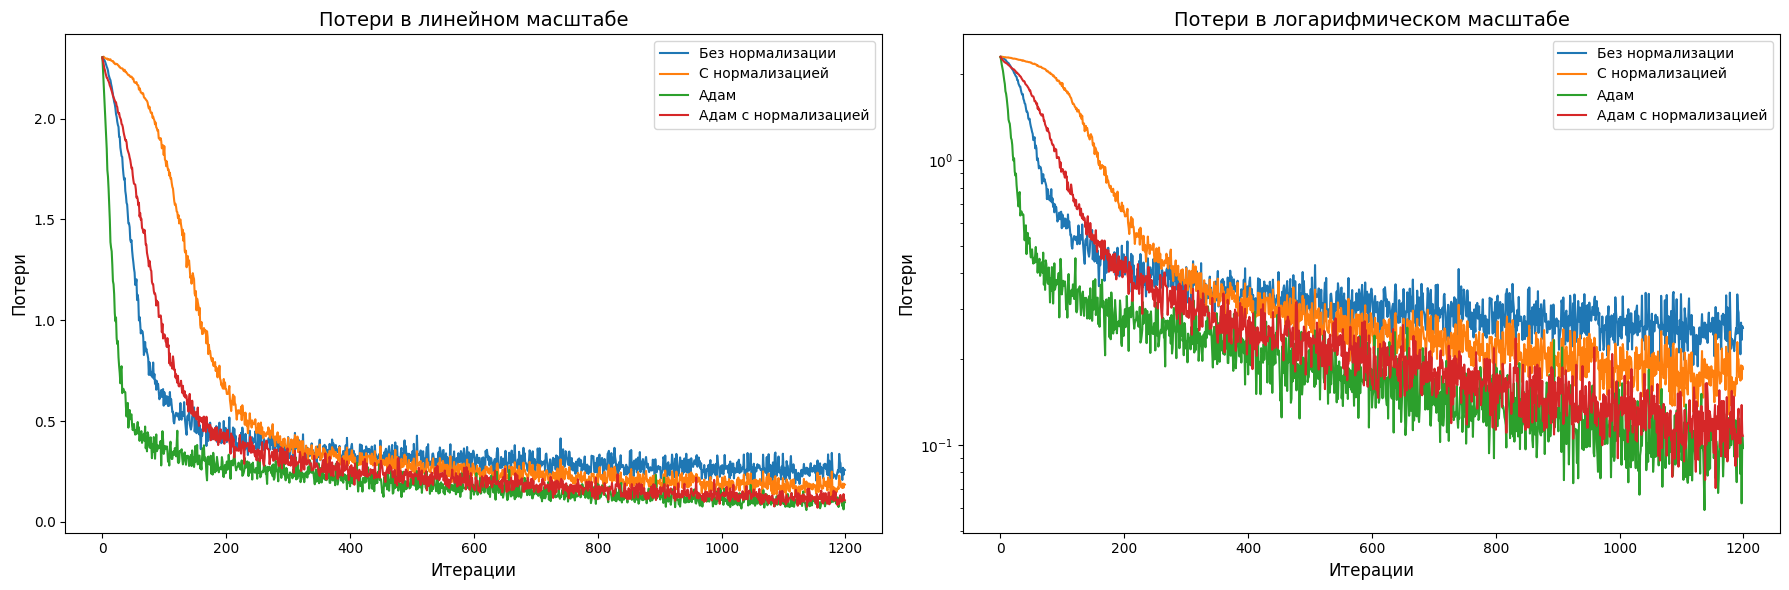

In [31]:
# Добавление потерь в историю
loss_histories["Адам"] = loss_adam
loss_histories["Адам с нормализацией"] = loss_adam_norm

# Создание двух подграфиков (один для линейного масштаба, второй для логарифмического)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 строка, 2 столбца

# Построение графика с линейным масштабом
for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

# Подписываем оси для линейного графика
axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

# Построение графика с логарифмическим масштабом
for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

# Устанавливаем логарифмический масштаб для оси y
axes[1].set_yscale("log")

# Подписываем оси для логарифмического графика
axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

# Компоновка графиков для лучшего отображения
plt.tight_layout()

# Показ графиков
plt.show()


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [32]:
# Анализ BatchNormalization для momentum_sgd:
# Точность: Модель с нормализацией дает точность 0.9507, что значительно выше, чем точность без нормализации (0.9308).
# Это означает, что нормализация улучшила производительность модели.
# Время: Время с нормализацией (327.90 секунд) немного больше, чем без неё (323.54 секунд), но разница составляет всего 4.36 секунд.
#Вывод:
#С нормализацией модель показала лучшую точность (0.9507 против 0.9308), что является важным фактором в большинстве задач машинного обучения.
# Разница во времени (4.36 секунд) незначительна, поэтому модель с нормализацией в целом является лучшей, так как она дает более высокую точность при минимальной потере времени.

In [33]:
# Анализ нормализации для Adam :
# Нормализация улучшает точность всего на 0.0001, что незначительно, но увеличивает время обучения на 12%.
# Если важна экономия времени, нормализация нецелесообразна, так как её влияние на точность минимально.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

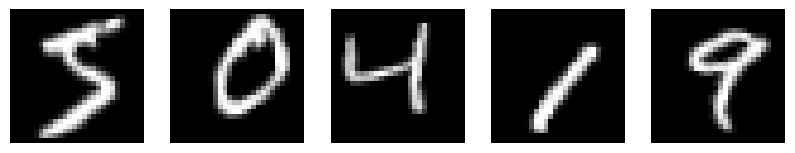

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")
X_train_r = np.array(X_train).reshape(-1, 28, 28, 1)
X_test = np.array(X_test).reshape(-1, 28 * 28) / 255.0

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

aug_X_train = []
aug_y_train = []

for x_batch, y_batch in datagen.flow(X_train_r, y_train, batch_size=500, shuffle=False):
    aug_X_train.append(x_batch)
    aug_y_train.append(y_batch)
    if len(aug_X_train) * 500 >= len(X_train):
        break

aug_X_train = np.concatenate(aug_X_train, axis=0).reshape(-1, 28 * 28)
aug_y_train = np.concatenate(aug_y_train, axis=0).astype(int)  # Приводим к int

# Создаем one-hot encoding для аугх меток
y_train_one_hot = np.eye(num_classes)[aug_y_train]

# Нормализуем изображения
X_train = aug_X_train / 255.0


# Визуализируем пример аугментации
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(aug_X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [35]:
# Функция для обучения модели
def train_model(net, model_name, optimizer, optimizer_config):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()
    optimizer_state = {}

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

In [36]:
# Функция для оценки модели
def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy

In [37]:
# Гиперпараметры
np.random.seed(42)
optimizer_config_sgd = {'learning_rate': 0.001, 'momentum': 0.9}

# Гиперпараметры для Adam
optimizer_config_adam = {
    'learning_rate': 0.001,
    'beta1': 0.9,       # Параметр для первого момента
    'beta2': 0.999,     # Параметр для второго момента
    'epsilon': 1e-8     # Малое число для предотвращения деления на 0
}

n_epoch = 10
batch_size = 500

# Создание модели для сравнения
best_net = Sequential()
best_net.add(Linear(28 * 28, 128))
best_net.add(LeakyReLU(slope=0.1))
best_net.add(Dropout(0.1))
best_net.add(Linear(128, 64))
batch_norm_2 = BatchNormalization(64)
batch_norm_2.alpha = 0.9
best_net.add(batch_norm_2)
best_net.add(ChannelwiseScaling(64))
best_net.add(LeakyReLU(slope=0.1))
best_net.add(Linear(64, 10))
best_net.add(LogSoftMax())

# Обучение моделей
print("\nОбучение Best Net:")
loss_best_net, time_best_net = train_model(best_net, "Best Net", adam_optimizer, optimizer_config_adam)


Обучение Best Net:
Эпоха 1: текущая потеря- 1.0948
Эпоха 2: текущая потеря- 0.4052
Эпоха 3: текущая потеря- 0.3560
Эпоха 4: текущая потеря- 0.2284
Эпоха 5: текущая потеря- 0.2282
Эпоха 6: текущая потеря- 0.2396
Эпоха 7: текущая потеря- 0.1534
Эпоха 8: текущая потеря- 0.1491
Эпоха 9: текущая потеря- 0.1211
Эпоха 10: текущая потеря- 0.1875


Print here your accuracy on test set. It should be around 90%.

In [38]:
# Оценка моделей
accuracy_best_net = evaluate_model(best_net, "Best Net")

# Вывод результатов
print(f"\nТочность на тестовых данных: {accuracy_best_net:.4f}")
print(f"Время обучения: {time_best_net:.2f} секунд")


Точность на тестовых данных: 0.9739
Время обучения: 361.61 секунд


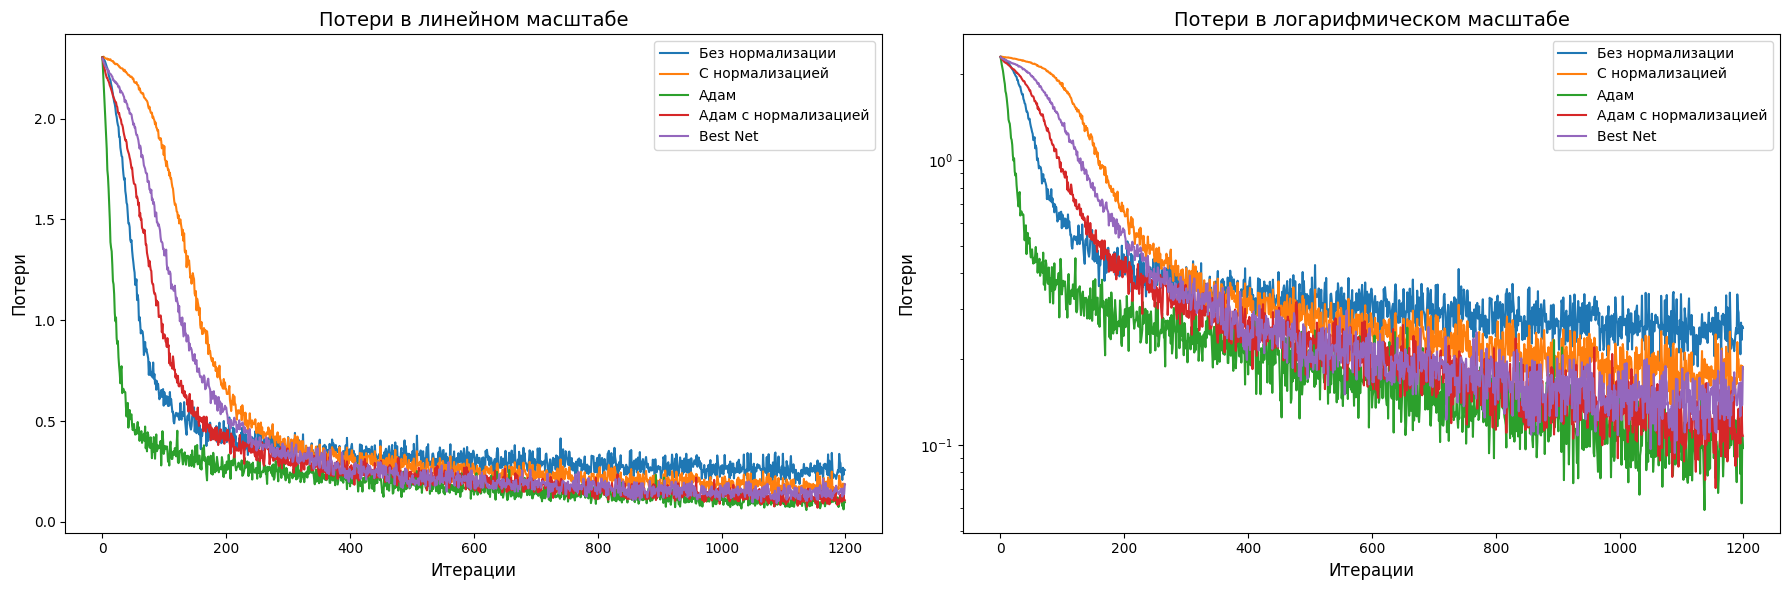

In [39]:
# Добавление потерь в историю
loss_histories["Best Net"] = loss_best_net

# Создание двух подграфиков (один для линейного масштаба, второй для логарифмического)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 строка, 2 столбца

# Построение графика с линейным масштабом
for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

# Подписываем оси для линейного графика
axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

# Построение графика с логарифмическим масштабом
for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

# Устанавливаем логарифмический масштаб для оси y
axes[1].set_yscale("log")

# Подписываем оси для логарифмического графика
axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

# Компоновка графиков для лучшего отображения
plt.tight_layout()

# Показ графиков
plt.show()

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import struct

In [45]:
# Чтение и предобработка данных
def read_images_labels(image_path, label_path):
    with open(image_path, 'rb') as f:
        magic_number, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    with open(label_path, 'rb') as f:
        magic_number, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return images, labels

def preprocess_data(X_train, X_test):
    X_train = np.array(X_train).reshape(-1, 28, 28) / 255.0
    X_test = np.array(X_test).reshape(-1, 28, 28) / 255.0
    return X_train, X_test

X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train, X_test = preprocess_data(X_train, X_test)

In [46]:
# Преобразуем данные в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 28*28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 28*28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [47]:
# Используем DataLoader для батчей
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [48]:
# Определение модели
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)  # Добавляем Dropout
        self.batch_norm = nn.BatchNorm1d(128)  # Добавляем BatchNormalization

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)  # Применяем Dropout
        x = self.fc2(x)
        return self.softmax(x)

In [49]:
# Инициализация модели, потерь и оптимизатора
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [50]:
# Обучение модели
def train_model(model, train_loader, optimizer, criterion, n_epochs=10):
    model.train()
    epoch_loss_history = []
    iteration_loss_history = []  # История потерь по итерациям
    start_time = time.time()

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            iteration_loss_history.append(loss.item())  # Сохраняем потери для каждой итерации

        avg_loss = running_loss / len(train_loader)
        epoch_loss_history.append(avg_loss)  # Сохраняем средние потери за эпоху
        print(f"Эпоха {epoch+1}, потеря: {avg_loss:.4f}")

    execution_time = time.time() - start_time
    return epoch_loss_history, iteration_loss_history, execution_time


In [51]:
# Оценка модели
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [52]:
# Обучение и оценка модели
epoch_loss_history, iteration_loss_history, train_time = train_model(model, train_loader, optimizer, criterion)

accuracy = evaluate_model(model, test_loader)

Эпоха 1, потеря: 0.5338
Эпоха 2, потеря: 0.2511
Эпоха 3, потеря: 0.1998
Эпоха 4, потеря: 0.1682
Эпоха 5, потеря: 0.1468
Эпоха 6, потеря: 0.1318
Эпоха 7, потеря: 0.1196
Эпоха 8, потеря: 0.1077
Эпоха 9, потеря: 0.1016
Эпоха 10, потеря: 0.0927


In [53]:
# Вывод результатов
print(f"\nТочность на тестовых данных: {accuracy:.4f}")
print(f"Время обучения: {train_time:.2f} секунд")


Точность на тестовых данных: 0.9695
Время обучения: 17.72 секунд


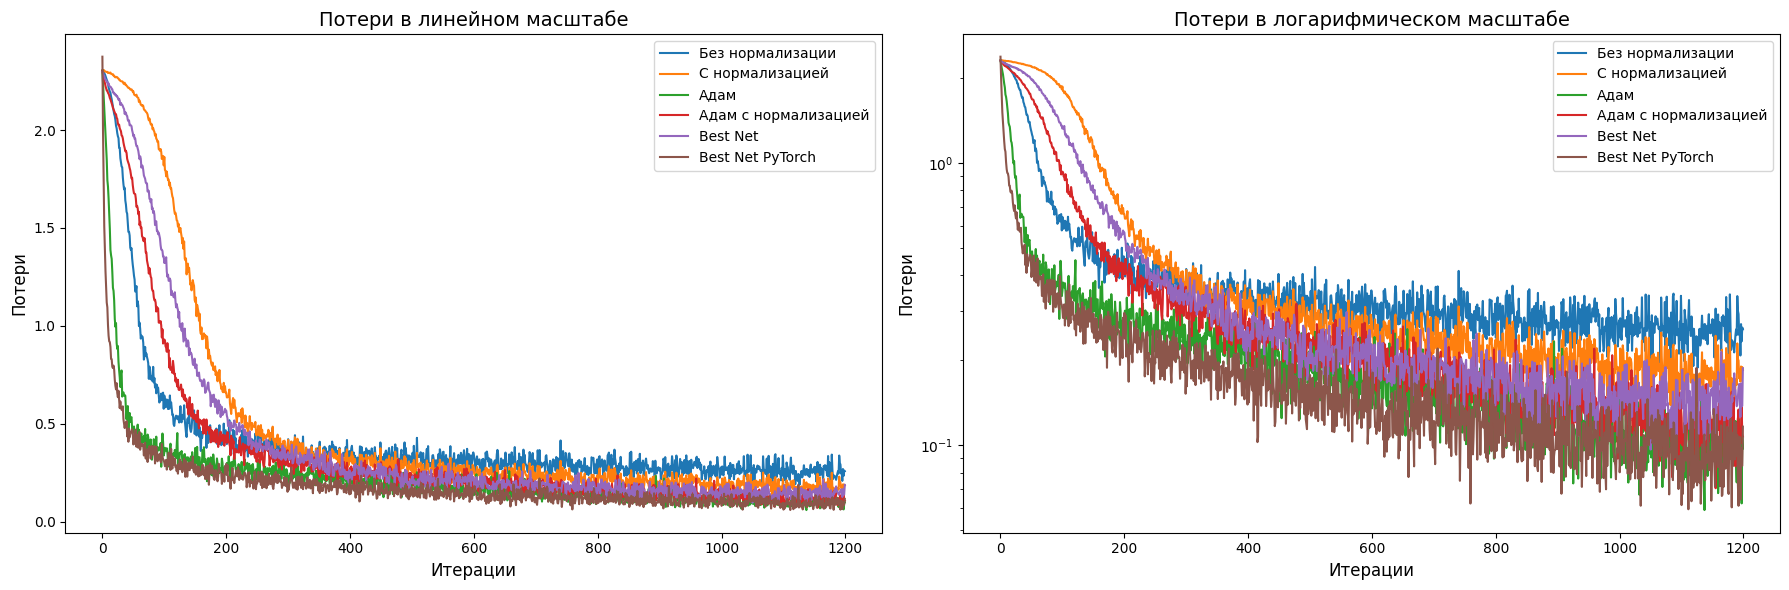

In [54]:
# Добавление потерь в историю
loss_histories["Best Net PyTorch"] = iteration_loss_history

# Создание двух подграфиков (один для линейного масштаба, второй для логарифмического)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 строка, 2 столбца

# Построение графика с линейным масштабом
for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

# Подписываем оси для линейного графика
axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

# Построение графика с логарифмическим масштабом
for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

# Устанавливаем логарифмический масштаб для оси y
axes[1].set_yscale("log")

# Подписываем оси для логарифмического графика
axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

# Компоновка графиков для лучшего отображения
plt.tight_layout()

# Показ графиков
plt.show()

Без нормализации
- Точность: 0.9308
- Время: 312.25 секунд

С нормализацией
- Точность: 0.9507
- Время: 318.88 секунд

Adam
- Точность: 0.9640
- Время: 315.49 секунд

Adam с нормализацией
- Точность: 0.9641
- Время: 326.02 секунд

Best Net
- Точность: 0.9739
- Время: 361.61 секунд

Best Net PyTorch
- Точность: 0.9695
- Время: 17.72 секунд



**Выводы:**
 - Включение нормализации в архитектуру сети улучшает точность моделей. Например, точность модели с нормализацией увеличилась с 93.08% до 95.07%.
 - Использование Adam вместо стандартного SGD позволяет добиться более высокой точности (96.40%) даже без нормализации.
 - Best Net, с использованием Batch Normalization, Dropout и LeakyReLU, показала наивысшую точность среди всех протестированных подходов — 97.39%. Однако время обучения составило 361.61 секунду, что делает её самой медленной
 - Реализация Best Net в PyTorch продемонстрировала сходную точность — 96.95%, что подтверждает корректность реализации и переносимости архитектуры. Однако время обучения составило лишь 17.72 секунды, что значительно быстрее реализации в других фреймворках

**Архитектура Best Net обеспечивает наивысшую точность, но её реализация в PyTorch является более производительной с точки зрения времени обучения.**